In [5]:
# Importar librerías necesarias
import os
import zipfile
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# -------------------------------
# Fijar semillas aleatorias para reproducibilidad
# -------------------------------
SEED = 5  # Semilla principal para reproducibilidad
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)  # Establece todas las semillas en TF 2.x

# Configurar operaciones para determinismo
tf.config.experimental.enable_op_determinism()

# -------------------------------
# 1. Extraer conjuntos de datos
# -------------------------------
zip_files = {
    'train': 'im_train.zip',
    'validation': 'im_validation.zip',
    'test': 'im_test.zip'
}

# Extracción de archivos ZIP si no existen
for folder, zip_file in zip_files.items():
    if not os.path.exists(folder):
        print(f"Extrayendo {zip_file} en la carpeta '{folder}/'...")
        with zipfile.ZipFile(zip_file, 'r') as z:
            z.extractall(folder)
        print("Extracción completada.")

# -------------------------------
# 2. Crear generadores de imágenes con augmentación mejorada
# -------------------------------
# Configuración de aumento de datos para entrenamiento (modificado)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest',
)

# Generador para evaluación de entrenamiento (sin aumentación)
eval_train_datagen = ImageDataGenerator(rescale=1./255)

# Generador para datos de validación y test (solo normalización)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de flujo de datos
train_generator = train_datagen.flow_from_directory(
    'train/',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Nuevo generador para evaluación de entrenamiento (sin aumentación)
train_eval_generator = eval_train_datagen.flow_from_directory(
    'train/',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,  # Importante para métricas consistentes
    seed=SEED
)

validation_generator = test_datagen.flow_from_directory(
    'validation/',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    'test/',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Pesos de clases ajustados (modificado)
class_weight = {
    0: 1.5,    # fish (↓ de 1.8)
    1: 0.8,    # jellyfish
    2: 1.2,    # penguin (↓ de 1.3)
    3: 1.0,    # puffin
    4: 1.5,    # shark (↓ de 1.5)
    5: 1.2,    # starfish
    6: 1.2     # stingray (↓ de 1.3)
}

# -------------------------------
# 3. Definir configuraciones de entrenamiento
# -------------------------------
configurations = [
    {'learning_rate': 0.0005, 'epochs': 40, 'fine_tune': True, 'unfreeze_layers': 20},
    #{'learning_rate': 0.0003, 'epochs': 50, 'fine_tune': True, 'unfreeze_layers': 25},
    #{'learning_rate': 0.001, 'epochs': 40, 'fine_tune': True, 'unfreeze_layers': 15}
]

# -------------------------------
# 4. Entrenamiento y evaluación mejorado
# -------------------------------
results = []
models_dict = {}
histories = {}
train_results = []

for i, config in enumerate(configurations):
    # Configuración del modelo
    lr = config['learning_rate']
    epochs = config['epochs']
    fine_tune = config['fine_tune']
    unfreeze_layers = config['unfreeze_layers']

    # Construcción del modelo
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

    # Congelación de capas
    if fine_tune:
        for layer in base_model.layers[:-unfreeze_layers]:
            layer.trainable = False
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True
    else:
        base_model.trainable = False

    # Arquitectura personalizada
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilación
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\nEntrenando configuración {i+1}: lr={lr}, epochs={epochs}, fine_tune={fine_tune}, unfreeze_layers={unfreeze_layers}")

    # Entrenamiento con callbacks mejorados
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
        ],
        class_weight=class_weight,
        shuffle=True
    )

    # Evaluación mejorada usando datos originales de entrenamiento
    train_loss, train_acc = model.evaluate(train_eval_generator)
    val_loss, val_acc = model.evaluate(validation_generator)

    # Almacenar resultados
    results.append({
        'config_index': i+1,
        'learning_rate': lr,
        'epochs': epochs,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    # Guardar modelo e histórico
    models_dict[i+1] = model
    histories[i+1] = history

    # Imprimir métricas de todas las configuraciones
print("\n=== Comparativa de Configuraciones ===")
for res in results:
    print(f"\nConfiguración {res['config_index']}:")
    print(f"LR: {res['learning_rate']} | Épocas: {res['epochs']}")
    print(f"Train Acc: {res['train_acc']:.4f} | Val Acc: {res['val_acc']:.4f}")
    print(f"Train Loss: {res['train_loss']:.4f} | Val Loss: {res['val_loss']:.4f}")

# Seleccionar mejor modelo basado en val_acc
best_config = max(results, key=lambda x: x['val_acc'])
best_model = models_dict[best_config['config_index']]
print(f"\nMejor configuración: #{best_config['config_index']}")

Found 1113 images belonging to 7 classes.
Found 1113 images belonging to 7 classes.
Found 245 images belonging to 7 classes.
Found 238 images belonging to 7 classes.

Entrenando configuración 1: lr=0.0005, epochs=40, fine_tune=True, unfreeze_layers=20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.2155 - loss: 2.4260 - val_accuracy: 0.2245 - val_loss: 1.9176 - learning_rate: 5.0000e-04
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.3718 - loss: 1.8829 - val_accuracy: 0.1918 - val_loss: 3.2037 - learning_rate: 5.0000e-04
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4564 - loss: 1.7741 - val_accuracy: 0.1959 - val_loss: 2.5351 - learning_rate: 5.0000e-04
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4201 - loss: 1.7475 - val_accuracy: 0.1510 - val_loss: 2.7984 - learning_rate: 5.0000e-04
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5058 - loss: 1.6196 - val_accuracy: 0.1429 - val_loss: 5.5257 - learning_rate: 5.0000e-04
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5009 - loss: 1.5778
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
35/35 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5011 - loss: 1


Comparativa de métricas entre configuraciones

Configuración 1:
LR: 0.0005 | Épocas: 40
Train Acc: 0.7628 | Val Acc: 0.7102
Train Loss: 0.6181 | Val Loss: 0.7437
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step

=== Métricas finales (Config 1) ===

● Entrenamiento:
Accuracy: 0.7628
Precision: 0.7684
Recall: 0.7628
F1-Score: 0.7624


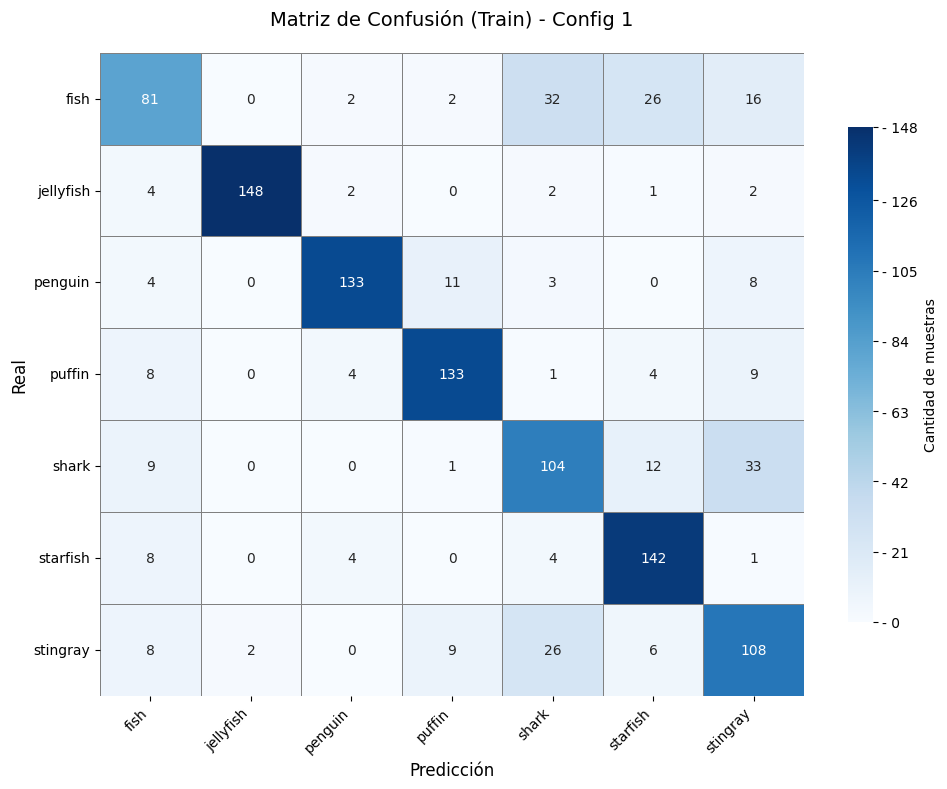

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 989ms/step

● Test:
Accuracy: 0.6975
Precision: 0.7024
Recall: 0.6975
F1-Score: 0.6920


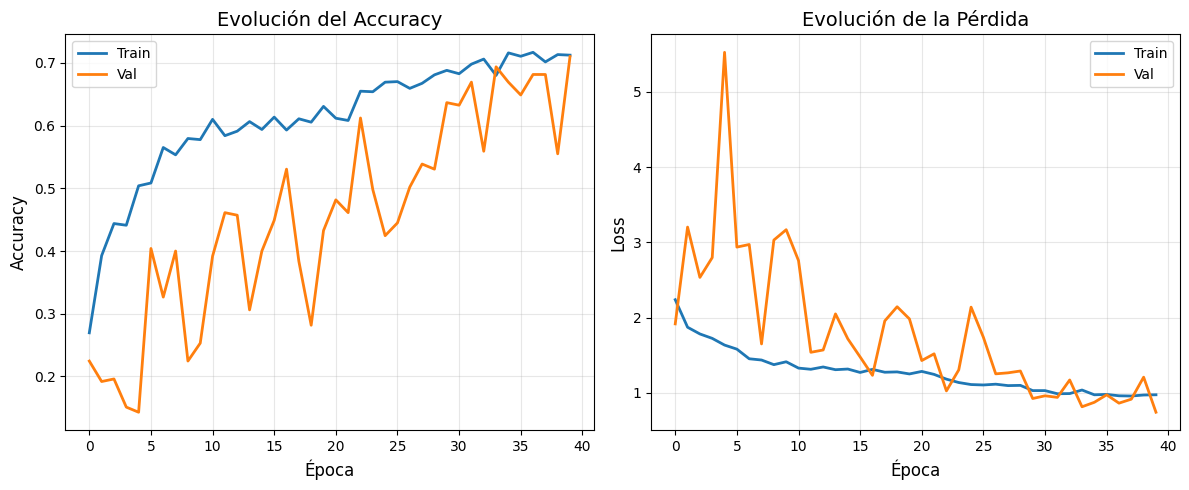

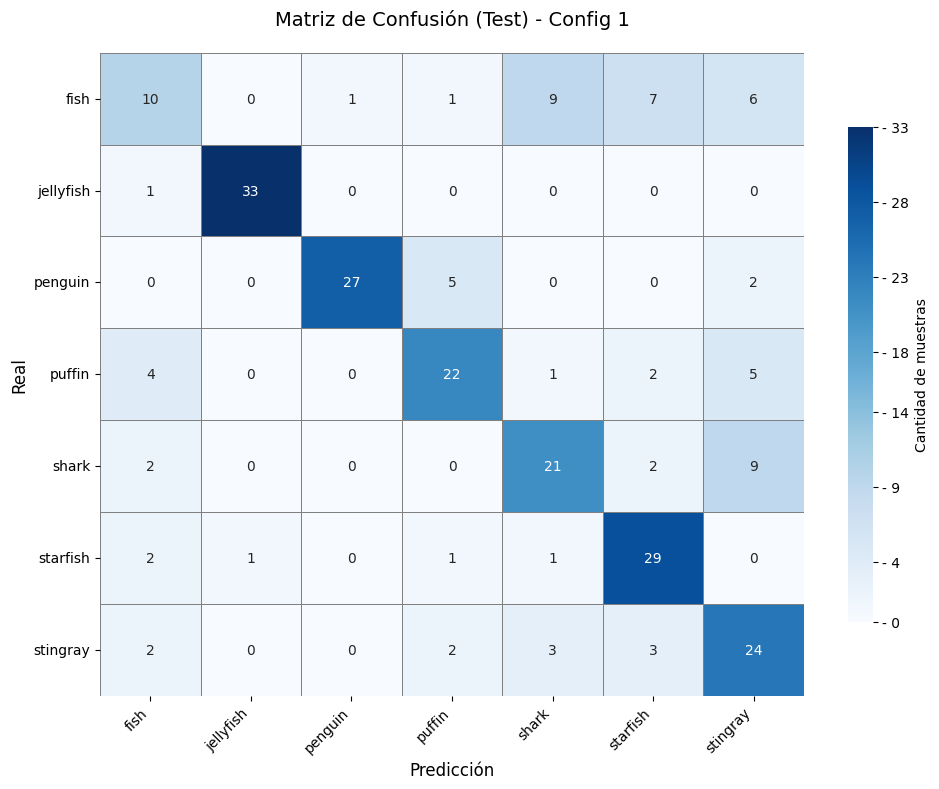


Reporte de Clasificación (Test)
              precision    recall  f1-score   support

        fish     0.4762    0.2941    0.3636        34
   jellyfish     0.9706    0.9706    0.9706        34
     penguin     0.9643    0.7941    0.8710        34
      puffin     0.7097    0.6471    0.6769        34
       shark     0.6000    0.6176    0.6087        34
    starfish     0.6744    0.8529    0.7532        34
    stingray     0.5217    0.7059    0.6000        34

    accuracy                         0.6975       238
   macro avg     0.7024    0.6975    0.6920       238
weighted avg     0.7024    0.6975    0.6920       238



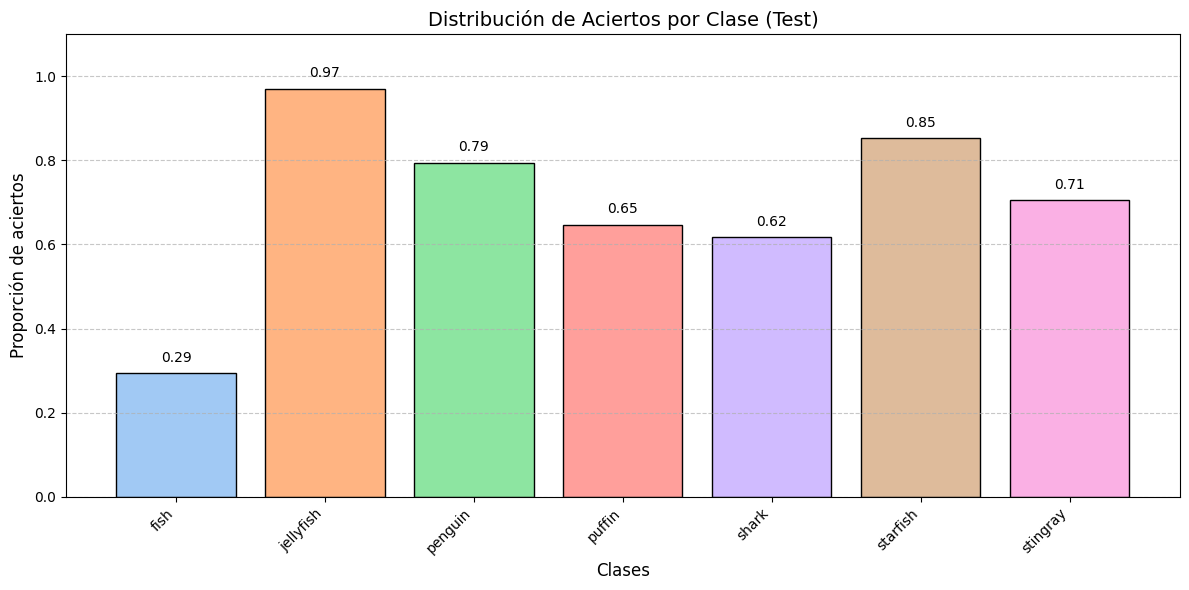

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# -------------------------------
# 5. Evaluación consistente del mejor modelo
# -------------------------------
if results:  # Eliminado 'train_results' que no estaba definido
    # 1. Comparativa de todas las configuraciones
    print("\n" + "="*55)
    print("Comparativa de métricas entre configuraciones")
    print("="*55)
    for i, result in enumerate(results):
        print(f"\nConfiguración {i+1}:")
        print(f"LR: {result['learning_rate']} | Épocas: {result['epochs']}")
        print(f"Train Acc: {result['train_acc']:.4f} | Val Acc: {result['val_acc']:.4f}")
        print(f"Train Loss: {result['train_loss']:.4f} | Val Loss: {result['val_loss']:.4f}")

    # 2. Selección del mejor modelo
    best_val_index = np.argmax([r['val_acc'] for r in results])
    best_val_result = results[best_val_index]
    best_model = models_dict[best_val_result['config_index']]  # Acceso por índice de configuración

    # 3. Evaluación en train con datos originales
    train_eval_generator.reset()
    y_pred_probs_train = best_model.predict(train_eval_generator, verbose=1)
    y_pred_train = np.argmax(y_pred_probs_train, axis=1)
    y_true_train = train_eval_generator.classes
    class_names = list(train_eval_generator.class_indices.keys())

    # 4. Métricas detalladas de train
    print("\n" + "="*45)
    print(f"=== Métricas finales (Config {best_val_index+1}) ===")
    print("="*45)
    print("\n● Entrenamiento:")
    print(f"Accuracy: {accuracy_score(y_true_train, y_pred_train):.4f}")
    print(f"Precision: {precision_score(y_true_train, y_pred_train, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true_train, y_pred_train, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true_train, y_pred_train, average='weighted'):.4f}")

    # 5. Matriz de confusión train
    plt.figure(figsize=(10, 8))
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    ax = sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5, linecolor='gray',
                    cbar_kws={'label': 'Cantidad de muestras', 'shrink': 0.77})

    cbar = ax.collections[0].colorbar
    max_val = cm_train.max()
    ticks = np.linspace(0, max_val, 8, dtype=int)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'- {tick}' for tick in ticks])

    plt.title(f"Matriz de Confusión (Train) - Config {best_val_index+1}", fontsize=14, pad=20)
    plt.xlabel("Predicción", fontsize=12)
    plt.ylabel("Real", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 6. Evaluación en test (definición correcta de y_true_test)
    test_generator.reset()
    y_pred_probs = best_model.predict(test_generator, verbose=1)
    y_pred_test = np.argmax(y_pred_probs, axis=1)
    y_true_test = test_generator.classes  # Definición añadida aquí

    # 7. Métricas detalladas de test
    print("\n● Test:")
    print(f"Accuracy: {accuracy_score(y_true_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_true_test, y_pred_test, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true_test, y_pred_test, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true_test, y_pred_test, average='weighted'):.4f}")

    # 8. Curvas de aprendizaje mejoradas
    history = histories[best_val_result['config_index']]  # Acceso por índice de configuración
    plt.figure(figsize=(12, 5))

    # Gráfico de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val', linewidth=2)
    plt.title('Evolución del Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Época', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val', linewidth=2)
    plt.title('Evolución de la Pérdida', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Época', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------------
# 6. Análisis detallado del mejor modelo
# -------------------------------
if 'best_model' in locals():
    # 1. Matriz de confusión test (variables ahora definidas)
    plt.figure(figsize=(10, 8))
    cm_test = confusion_matrix(y_true_test, y_pred_test)
    ax = sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5, linecolor='gray',
                    cbar_kws={'label': 'Cantidad de muestras', 'shrink': 0.77})

    cbar = ax.collections[0].colorbar
    max_val = cm_test.max()
    ticks = np.linspace(0, max_val, 8, dtype=int)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'- {tick}' for tick in ticks])

    plt.title(f"Matriz de Confusión (Test) - Config {best_val_index+1}", fontsize=14, pad=20)
    plt.xlabel("Predicción", fontsize=12)
    plt.ylabel("Real", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 2. Reporte de clasificación detallado
    print("\n" + "="*45)
    print("Reporte de Clasificación (Test)")
    print("="*45)
    print(classification_report(y_true_test, y_pred_test,
                               target_names=class_names,
                               digits=4))

    # 3. Visualización de distribución de aciertos por clase
    plt.figure(figsize=(12, 6))
    class_acc = []
    for i, class_name in enumerate(class_names):
        class_indices = np.where(y_true_test == i)[0]
        acc = np.mean(y_pred_test[class_indices] == i) if len(class_indices) > 0 else 0
        class_acc.append(acc)

    bars = plt.bar(range(len(class_names)), class_acc,
                 color=sns.color_palette("pastel"),
                 edgecolor='black')

    # Añadir valores en las barras
    for bar, acc in zip(bars, class_acc):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{acc:.2f}', ha='center', va='bottom')

    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.title("Distribución de Aciertos por Clase (Test)", fontsize=14)
    plt.ylabel("Proporción de aciertos", fontsize=12)
    plt.xlabel("Clases", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
